In [1]:
import tqdm

import h5py
import numpy as np
import matplotlib.pyplot as plt
import corner
import scipy.interpolate as interpolate

from fiesta.train.DataManager import DataManager
from fiesta.train.AfterglowData import RunPyblastafterglow

file = "./model/pyblastafterglow_raw_data.h5"
fix_file = "./model/fix_file_early_times_2.h5"

In [42]:
with h5py.File(fix_file, "r") as f:
    problematic_train_X = f["train"]["X"][:]
    problematic_val_X = f["val"]["X"][:]
    problematic_test_X = f["test"]["X"][:]

    
    print("train is nan? inf?", np.any(np.isnan(f["train"]["y"])), np.any(np.isinf(f["train"]["y"])))
    print("val is nan? inf?", np.any(np.isnan(f["val"]["y"])), np.any(np.isinf(f["val"]["y"])))
    print("test is nan? inf?", np.any(np.isnan(f["test"]["y"])), np.any(np.isinf(f["test"]["y"])))


train is nan? inf? True True
val is nan? inf? False True
test is nan? inf? False False


In [72]:
with h5py.File(fix_file, "r") as f:
    train_nans = np.unique(np.where(np.isnan(f["train"]["y"]))[0])

train_nans = np.delete(train_nans, 30)
print(train_nans)

[  3   9  13  31  36  52  62  63  80 156 170 172 174 176 191 200 207 219
 236 262 270 278 309 311 327 343 386 447 451 453 517 533 536]


In [7]:
def find_old_ind(X_old, X):

    inds = []

    for x in X:
        inds.append(np.where(X_old == x)[0][0])
    
    return np.array(inds)


with h5py.File(file, "r") as f:
    problematic_train_ind = find_old_ind(f["train"]["X"][:], problematic_train_X)
    problematic_val_ind = find_old_ind(f["val"]["X"][:], problematic_val_X)
    problematic_test_ind = find_old_ind(f["test"]["X"][:], problematic_test_X)



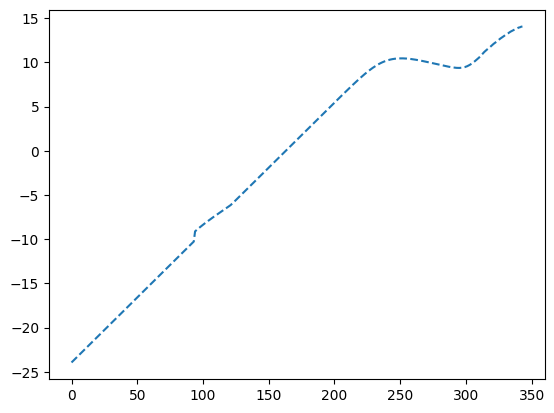

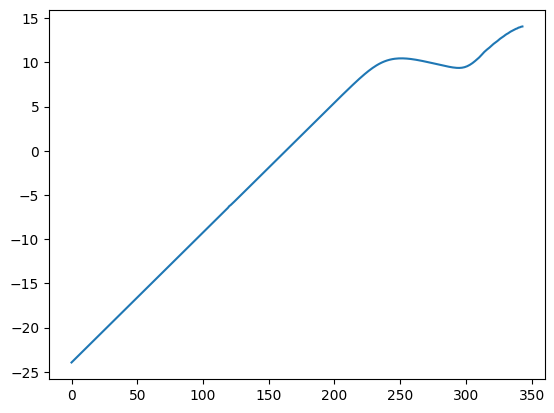

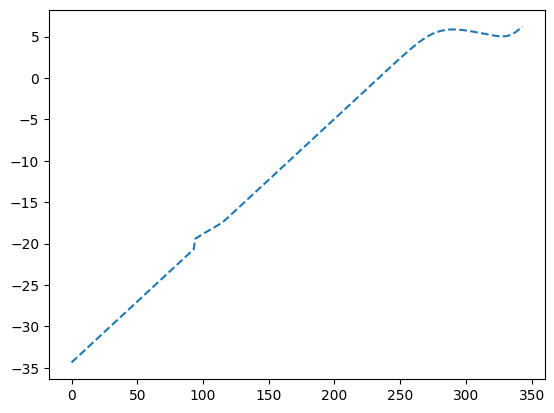

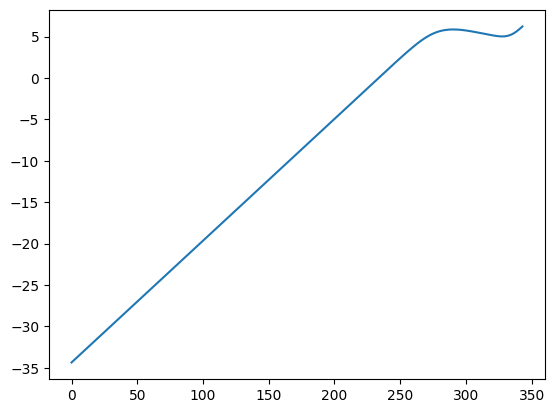

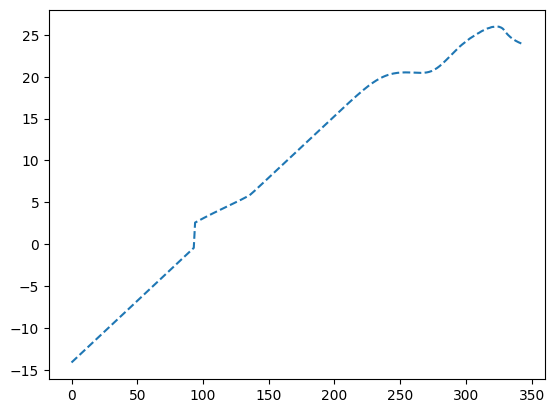

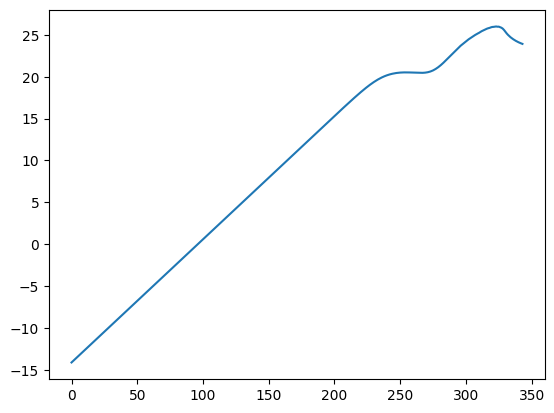

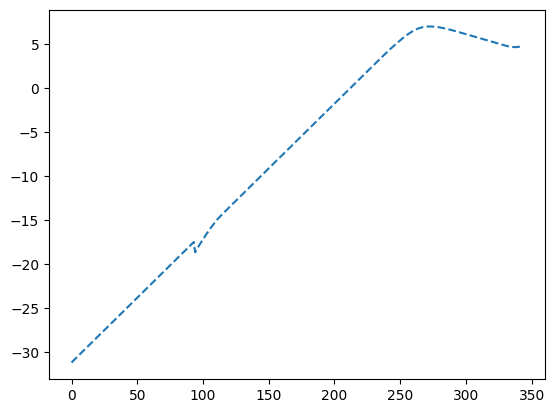

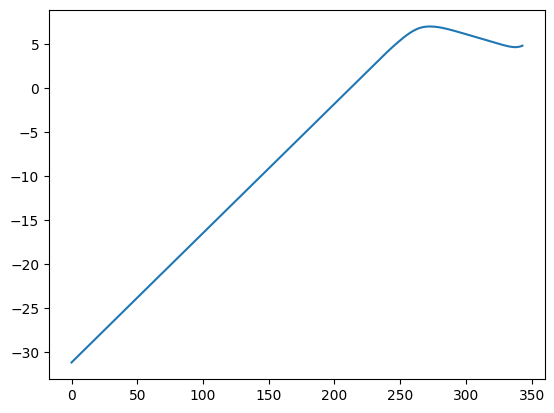

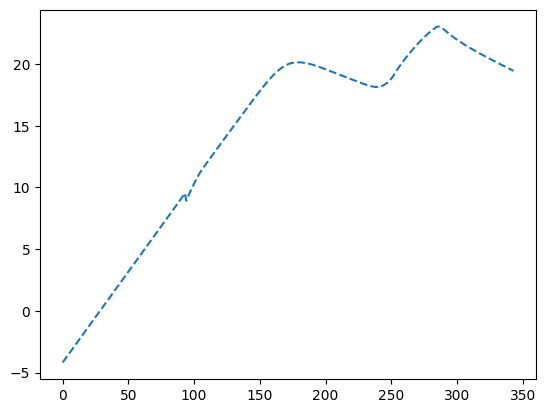

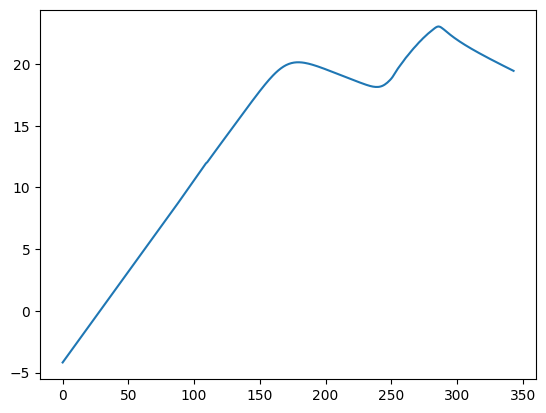

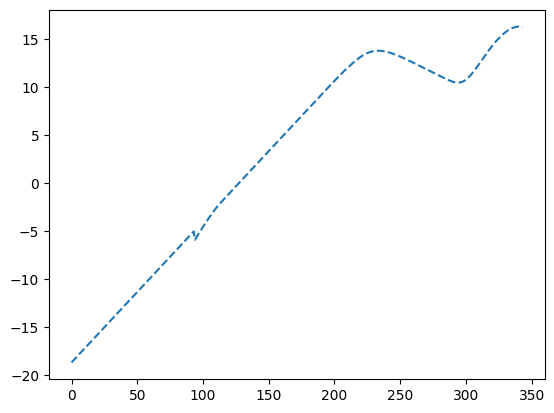

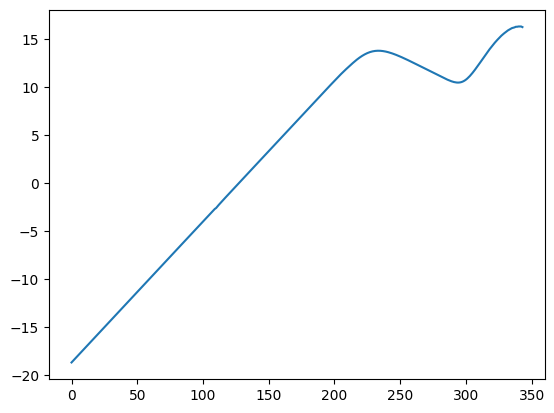

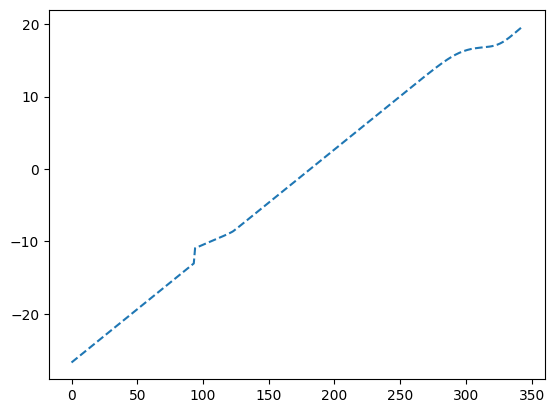

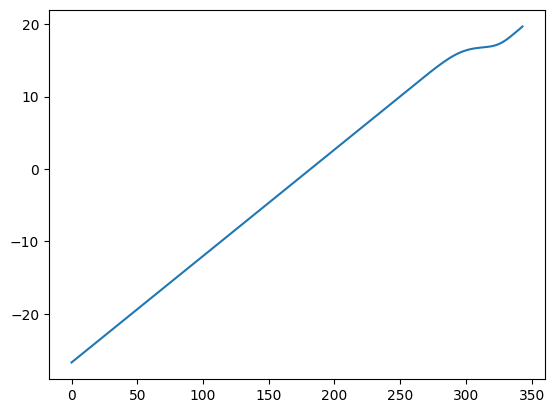

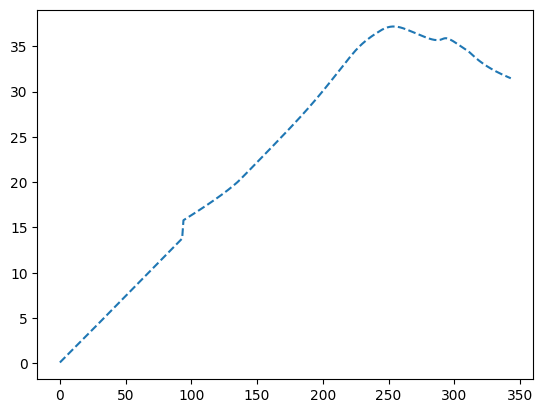

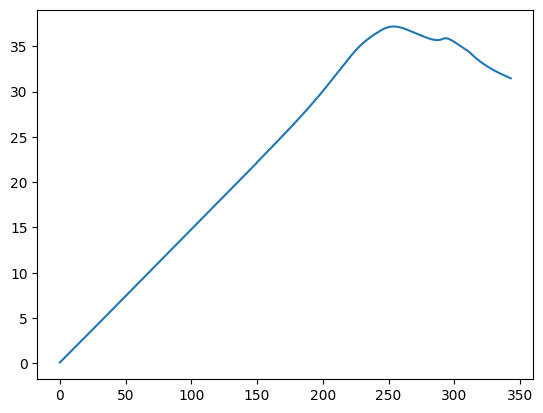

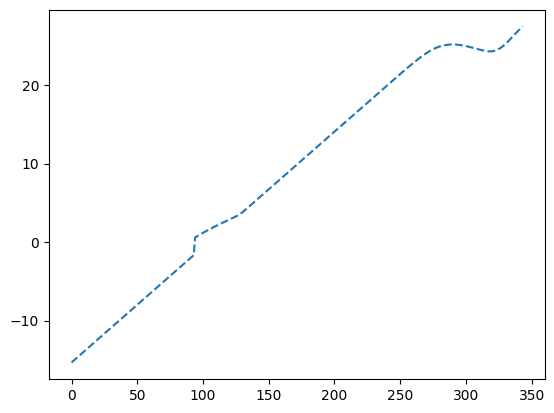

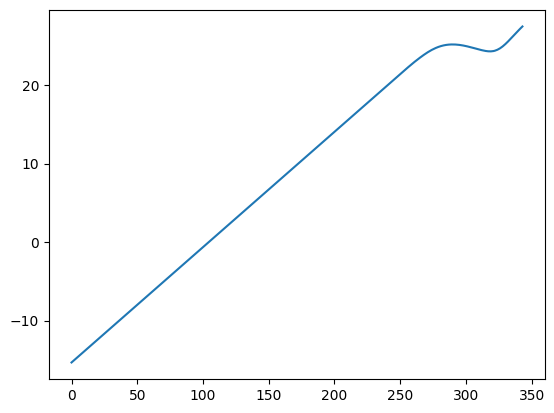

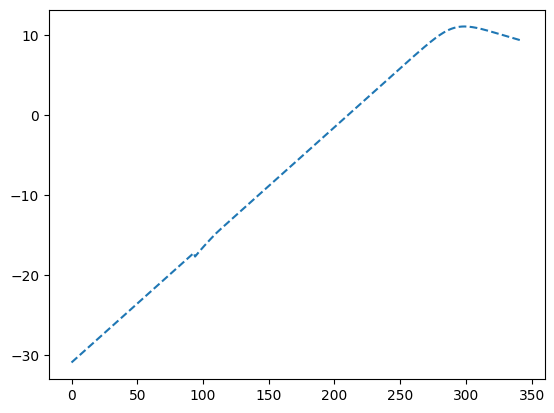

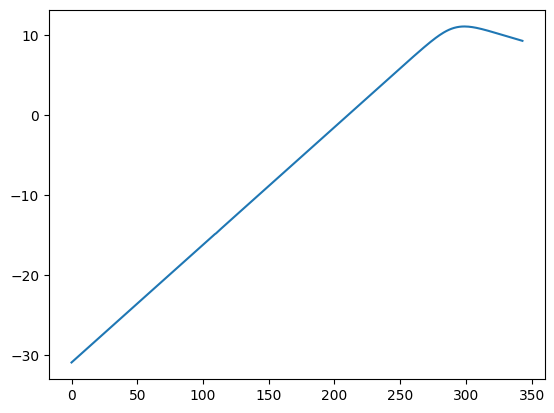

In [103]:
with h5py.File(file, "r+") as f:
    
    y_old = f["train"]["y"][np.sort(problematic_train_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["train"]["y"][:])[np.argsort(problematic_train_ind)].reshape(-1, 256, 94)

    nan_inds = np.isnan(y_new[:,0,0])
    interp_nans = interpolate.interp1d(x=np.log10(f["times"][:94]), y=y_old[nan_inds,:,:94], axis=-1, fill_value="extrapolate")
    y_without_nans = interp_nans(np.log10(f["times"][94:150]))
    for j in range(10):
        plt.plot(y_old[nan_inds,0,:][j], linestyle="dashed")
        plt.show()
        xx = int(input(f"Enter the end index:" ))
        y_old[np.where(nan_inds)[0][j],:, 94:xx] = y_without_nans[j,:,:xx-94]
        plt.plot(y_old[nan_inds,0,:][j])
        plt.show()

## OVERWRITE

In [ ]:
with h5py.File(file, "r+") as f:
    
    y_old = f["train"]["y"][np.sort(problematic_train_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["train"]["y"][:])[np.argsort(problematic_train_ind)].reshape(-1, 256, 94)
    y_new = np.maximum(-50, y_new)

    nan_inds = np.isnan(y_new[:,0,0])
    interp_nans = interpolate.interp1d(x=np.log10(f["times"][:94]), y=y_old[nan_inds,:,:94], axis=-1, fill_value="extrapolate")
    y_without_nans = interp_nans(np.log10(f["times"][94:160]))
    for j in range(np.sum(nan_inds)):
        plt.plot(y_old[nan_inds,0,:][j], linestyle="dashed")
        plt.xlim(90, 160)
        plt.show()
        xx = int(input(f"Enter the end index:" ))
        y_old[np.where(nan_inds)[0][j],:, 94:xx] = y_without_nans[j,:,:xx-94]
        plt.plot(y_old[nan_inds,0,:][j])
        plt.show()
    
    y_old[~nan_inds,:,:94] = y_new[~nan_inds,:,:]

    f["train"]["y"][np.sort(problematic_train_ind)] = y_old.reshape(-1, f["nus"].shape[0]*f["times"].shape[0])

In [114]:
with h5py.File(file, "r+") as f:
    
    y_old = f["val"]["y"][np.sort(problematic_val_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["val"]["y"][:])[np.argsort(problematic_val_ind)].reshape(-1, 256, 94)
    
   
    y_new = np.maximum(-50, y_new)
    y_old[:,:,:94] = y_new

    f["val"]["y"][np.sort(problematic_val_ind)] = y_old.reshape(-1, f["nus"].shape[0]*f["times"].shape[0])

In [115]:
with h5py.File(file, "r+") as f:
    
    y_old = f["test"]["y"][np.sort(problematic_test_ind)].reshape(-1, f["nus"].shape[0], f["times"].shape[0])

    with h5py.File(fix_file, "r") as fix_f:
        y_new = (fix_f["test"]["y"][:])[np.argsort(problematic_test_ind)].reshape(-1, 256, 94)
    
    
    y_new = np.maximum(-50, y_new)
    y_old[:,:,:94] = y_new

    f["test"]["y"][np.sort(problematic_test_ind)] = y_old.reshape(-1, f["nus"].shape[0]*f["times"].shape[0])

# OVERWRITE remaining ones

In [ ]:
with h5py.File(file, "r+") as f:

    problematic_ind = np.where(np.abs(f["train"]["y"][:, 94] - f["train"]["y"][:, 93])>0.33)[0]
    problematic_val_X = f["train"]["X"][problematic_ind]

    problematic_y = f["train"]["y"][problematic_ind].reshape(-1, f["nus"].shape[0], f["times"].shape[0])
    

    interp_problematic = interpolate.interp1d(x=np.log10(f["times"][:94]), y=problematic_y[:,:,:94], axis=-1, fill_value="extrapolate")
    y_interped = interp_problematic(np.log10(f["times"][94:200]))
    for j in range(len(problematic_ind)):
        plt.plot(problematic_y[j,0,:], linestyle="dashed")
        plt.plot(problematic_y[j,125,:], linestyle="dashed")
        plt.plot(problematic_y[j,-1,:], linestyle="dashed")
        plt.xlim(0, 200)
        plt.show()
        xx = int(input(f"Enter the end index:" ))
        problematic_y[j,:,94:xx] = y_interped[j,:,:xx-94]
        plt.plot(problematic_y[j,0,:])
        plt.plot(problematic_y[j,125,:])
        plt.plot(problematic_y[j,-1,:])
        plt.show()

        overwrite = str(input(f"Overwrite?"))

        if overwrite=="y":
            f["train"]["y"][problematic_ind[j]] = problematic_y[j].reshape(f["nus"].shape[0]*f["times"].shape[0])

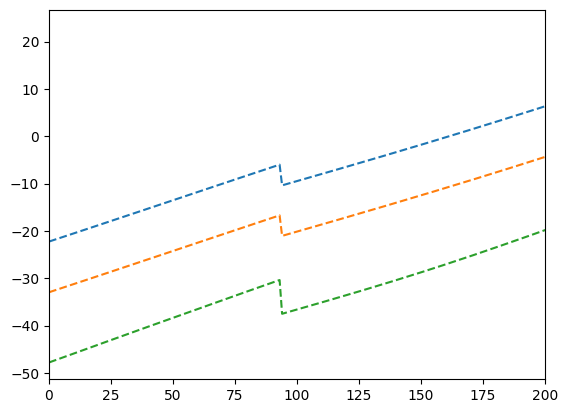

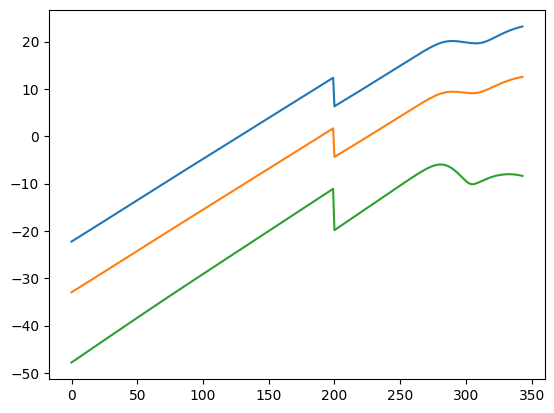

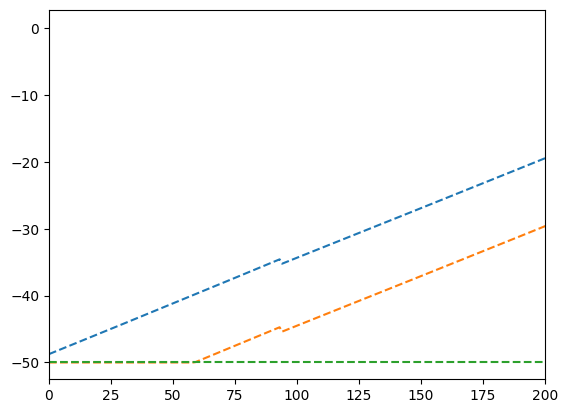

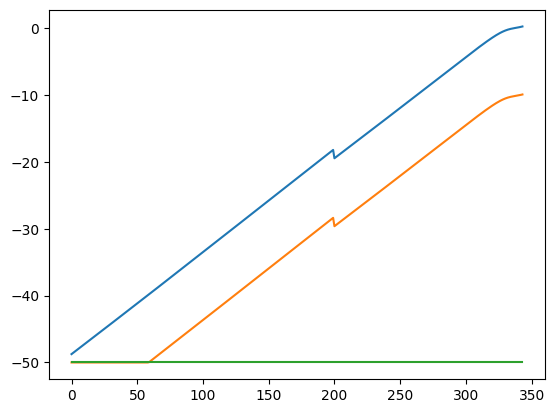

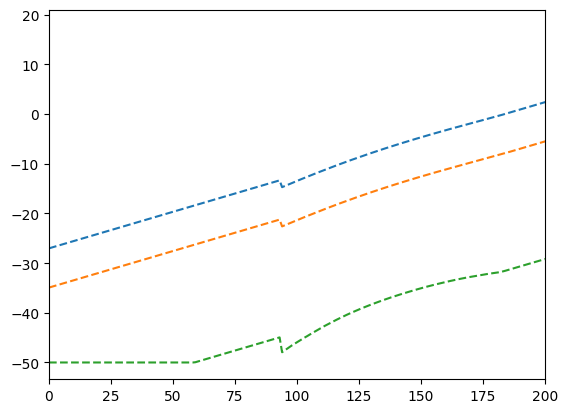

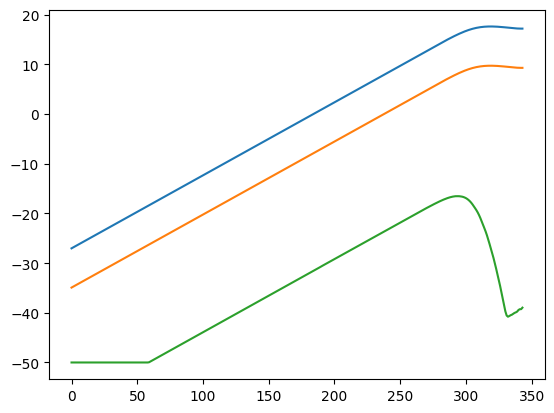

In [11]:
with h5py.File(file, "r+") as f:

    problematic_ind = np.where(np.abs(f["val"]["y"][:, 94] - f["val"]["y"][:, 93])>0.5)[0]
    problematic_val_X = f["val"]["X"][problematic_ind]

    problematic_y = f["val"]["y"][problematic_ind].reshape(-1, f["nus"].shape[0], f["times"].shape[0])
    

    interp_problematic = interpolate.interp1d(x=np.log10(f["times"][:94]), y=problematic_y[:,:,:94], axis=-1, fill_value="extrapolate")
    y_interped = interp_problematic(np.log10(f["times"][94:200]))
    for j in range(len(problematic_ind)):
        plt.plot(problematic_y[j,0,:], linestyle="dashed")
        plt.plot(problematic_y[j,125,:], linestyle="dashed")
        plt.plot(problematic_y[j,-1,:], linestyle="dashed")
        plt.xlim(0, 200)
        plt.show()
        xx = int(input(f"Enter the end index:" ))
        problematic_y[j,:,94:xx] = y_interped[j,:,:xx-94]
        plt.plot(problematic_y[j,0,:])
        plt.plot(problematic_y[j,125,:])
        plt.plot(problematic_y[j,-1,:])
        plt.show()

        overwrite = str(input(f"Overwrite?"))

        if overwrite=="y":
            f["val"]["y"][problematic_ind[j]] = problematic_y[j].reshape(f["nus"].shape[0]*f["times"].shape[0])

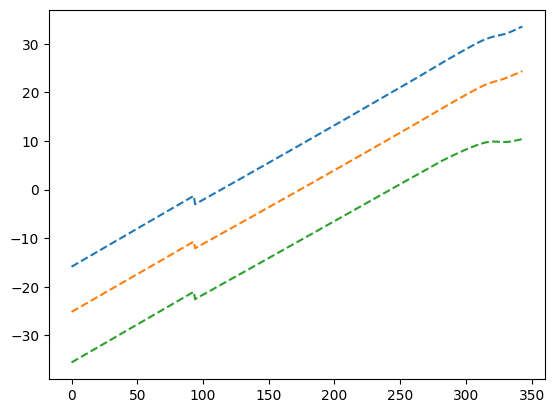

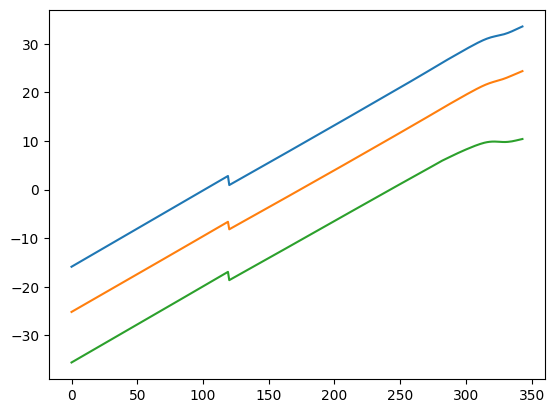

In [7]:
with h5py.File(file, "r+") as f:

    problematic_ind = np.where(np.abs(f["test"]["y"][:, 94] - f["test"]["y"][:, 93])>0.33)[0]
    problematic_test_X = f["test"]["X"][problematic_ind]

    problematic_y = f["test"]["y"][problematic_ind].reshape(-1, f["nus"].shape[0], f["times"].shape[0])
    

    interp_problematic = interpolate.interp1d(x=np.log10(f["times"][:94]), y=problematic_y[:,:,:94], axis=-1, fill_value="extrapolate")
    y_interped = interp_problematic(np.log10(f["times"][94:200]))
    for j in range(len(problematic_ind)):
        plt.plot(problematic_y[j,0,:], linestyle="dashed")
        plt.plot(problematic_y[j,125,:], linestyle="dashed")
        plt.plot(problematic_y[j,-1,:], linestyle="dashed")
        plt.show()
        xx = int(input(f"Enter the end index:" ))
        problematic_y[j,:,94:xx] = y_interped[j,:,:xx-94]
        plt.plot(problematic_y[j,0,:])
        plt.plot(problematic_y[j,125,:])
        plt.plot(problematic_y[j,-1,:])
        plt.show()
    
    

    #f["test"]["y"][problematic_ind] = problematic_y.reshape(-1, f["nus"].shape[0]*f["times"].shape[0])

## Check overwritten h5 file

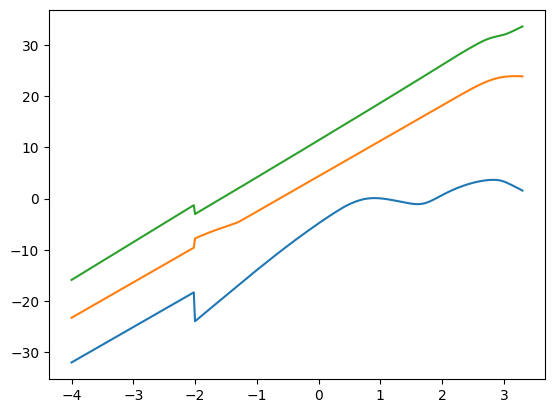

In [2]:
with h5py.File(file) as f:
    
    times = f["times"][:]
    nus = f["nus"][:]

    problematic_ind = np.where(np.abs(f["train"]["y"][:, 94] - f["train"]["y"][:, 93])>0.33)[0]
    problematic_train_X = f["train"]["X"][problematic_ind]

    problematic_ind = np.where(np.abs(f["val"]["y"][:, 94] - f["val"]["y"][:, 93])>0.33)[0]
    problematic_val_X = f["val"]["X"][problematic_ind]

    problematic_ind = np.where(np.abs(f["test"]["y"][:, 94] - f["test"]["y"][:, 93])>0.33)[0]
    problematic_test_X = f["test"]["X"][problematic_ind]
    problematic_y = f["test"]["y"][problematic_ind]

    for ind in problematic_ind:
        plt.plot(np.log10(f["times"][:]), f["test"]["y"][ind,:344])


In [28]:

pbag = RunPyblastafterglow(jet_type=0,
                           times=times,
                           nus=nus[:3],
                           parameter_names=["inclination_EM", "log10_E0", "thetaCore", "alphaWing", "log10_n0", "p", "log10_epsilon_e", "log10_epsilon_B", "Gamma0"],
                           X = [problematic_test_X[2] ],
                           tb0=1e-4,
                           tb1=1e10,
                           ntb=900,
                           path_to_exec="/home/aya/work/hkoehn/fiesta/PyBlastAfterglowMag/src/pba.out",
                           loglevel="info")
_, log_mJys = pbag(0)

[ INFO    ] : [ main.cpp:149 ] : Computation tgrid = [0.0001, 9.64816e+09] n=900
[ INFO    ] : [ main.cpp:151 ] : Output      tgrid = [0.0001, 9.64816e+09] n=900
[ INFO    ] : [ model_magnetar.h:569 ] : Magnetar is not initialized and will not be considered.
 mom=157.394 Gamma=157.397 beta=0.99998
 mom=146.228 Gamma=146.231 beta=0.999977
 mom=126.23 Gamma=126.234 beta=0.999969
 mom=101.275 Gamma=101.28 beta=0.999951
 mom=75.5589 Gamma=75.5655 beta=0.999912
 mom=52.4769 Gamma=52.4864 beta=0.999818
 mom=33.9978 Gamma=34.0125 beta=0.999568
 mom=20.6318 Gamma=20.656 beta=0.998827
 mom=11.8256 Gamma=11.8678 beta=0.996444
 mom=6.50339 Gamma=6.57982 beta=0.988384
 mom=3.52104 Gamma=3.66029 beta=0.961957
 mom=1.93463 Gamma=2.1778 beta=0.888343
[ INFO    ] : [ ejecta_id.h:220 ] :  1D ID has theta_wing=0.547534 theta_core=0.16765
[ INFO    ] : [ ejecta_id.h:279 ] : Initial data loaded with nshells=1 m_nlayers=12
[ INFO    ] : [ ejecta_id.h:301 ] : Angular grids are initialized. nshells=1 m_nlaye

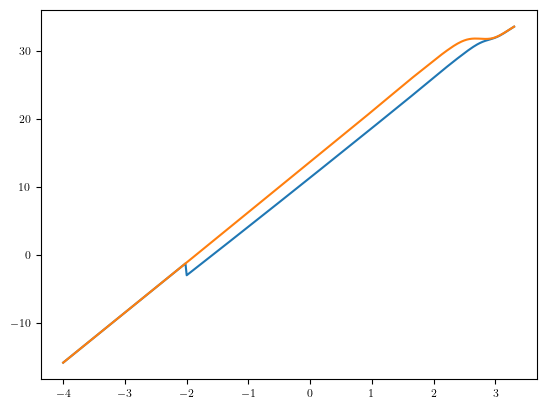

In [29]:
plt.plot(np.log10(times), (problematic_y[2,:344]))
plt.plot(np.log10(times), log_mJys.reshape(3, len(times) )[0] )
